In [2]:
from lattice_generation import GeneratedLatticeImage

## Generate Data

Given a number of lattice sites and number of pixels per lattice site, as well as a total CCD sidelength, an array is generated which mimics the CCD output for real data. On this array, a specified number of atoms are uniformly and randomly placed within the optical lattice region. From those atoms, assuming that they are Gaussian emitters, some number of photons are sampled. To simulate spurious photons on the camera, some number counts are drawn from a Poisson distribution and they are uniformly and randomly placed on the lattice and the rest of the CCD.

Specify parameters to generate data:

In [8]:
N = 10 #Number of lattice sites along each axis
M = 10 #Number of pixels per lattice site
N_atom = 40 #Number of atoms to be randomly placed
N_photon = 300 #Number of photons atoms fluoresce
std = 3 #Width of the normal distribution that counts are sampled from
N_backg = 1000 #Number of samples drawn from the Poisson distribution for the background noise
lam_backg = 10 #Expectation interval of the Poisson dark count event

Generate the data with specified parameters

In [9]:
lattice_image = GeneratedLatticeImage(
    N=N,
    M=M,
    N_atom=N_atom,
    N_photon=N_photon,
    std=std,
    N_backg=N_backg, 
    lam_backg=lam_backg,
    CCD_resolution=N*M,
    lattice_origin=(0,0)
)

Visualize the generated data

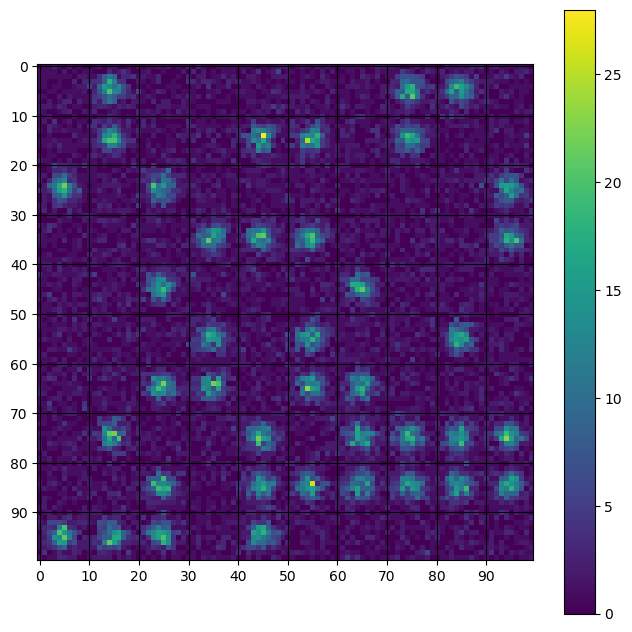

In [10]:
lattice_image.grid_plot()

Generated data also gives the actual, binary distribution of atoms on the lattice with `lattice_image.actual_lattice`

## Analysis Part

To analyze the generated data and find the probability of occupation by an atom for each lattice site a generative mixture model is used on `pymc3`. The likelihood for that model is defined as:

$$ L = P N(r_c, \sigma) + (1-P) U(r_1, r_2) $$

where $N(r_c, \sigma)$ is normal distribution centered at each lattice site with standard devitation $\sigma$ and $U(r_1,r_2)$ is uniform distribution between $r_1$ and $r_2$. $P$ is the probability that the lattice site is occupied is maximized if the counts are coming from a Gaussian distribution. For $P$ a flat prior between $0$ and $1$ is given, the MAP value for the parameter P is used as the result.

In [11]:
from analysis_models import mixture_model
from lattice_analyzer import LatticeImageAnalyzer

Specify the model for the anmixture_model_v1the data with that model given the generated data results

In [12]:
# Instantiate the Analyzer with the lattice_image object created above
q = LatticeImageAnalyzer(lattice_image)

# Run analysis
%time q.sample_mixture_model(mixture_model, nsteps = 500, nchains = 2)

Multiprocess sampling (2 chains in 4 jobs)
CompoundStep
>NUTS: [sigma_b, sigma_a, Ab, Aa, P]
>BinaryGibbsMetropolis: [q]
Sampling 2 chains, 0 divergences: 100%|█████████████████████████████████████████| 2000/2000 [00:25<00:00, 79.31draws/s]
The acceptance probability does not match the target. It is 0.8853672253819707, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9009083123093403, but should be close to 0.8. Try to increase the number of tuning steps.


Wall time: 57.8 s


The model yields the probability that each lattice site is occupied by an atom

In [13]:
q.print_occupation()

[[0. 1. 0. 0. 0. 0. 0. 1. 1. 0.]
 [0. 1. 0. 0. 1. 1. 0. 1. 0. 0.]
 [1. 0. 1. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 1. 1. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 1. 0. 0. 1. 0.]
 [0. 0. 1. 1. 0. 1. 1. 0. 0. 0.]
 [0. 1. 0. 0. 1. 0. 1. 1. 1. 1.]
 [0. 0. 1. 0. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 0. 1. 0. 0. 0. 0. 0.]]


Compare this result with the actual distribution of atoms

In [14]:
print(lattice_image.actual_lattice)

[[0. 1. 0. 0. 0. 0. 0. 1. 1. 0.]
 [0. 1. 0. 0. 1. 1. 0. 1. 0. 0.]
 [1. 0. 1. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 1. 1. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 1. 0. 0. 1. 0.]
 [0. 0. 1. 1. 0. 1. 1. 0. 0. 0.]
 [0. 1. 0. 0. 1. 0. 1. 1. 1. 1.]
 [0. 0. 1. 0. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 0. 1. 0. 0. 0. 0. 0.]]


# Analysis of the Real Data with Deconvolution

Raw data consists of 6 lattice shots and a PSF. Data is collected with a high-resolution objective and an EMCDD camera. Analysis starts with selecting a region of interest. Then image is rotated such that the lattice is oriented vertically. Then Wiener-Hunt deconvolution is performed given the point-spread function. After this the deconvoluted image is shifted such that atom centers match the lattice locations of the lattice. Finally, photon counts on lattice sites are histogrammed and a threshold is calculated. With this threshold the deconvoluted image is binarized and the occupation numbers on each lattice is found.

## Wiener-Hunt Deconvolution (source: Wikipedia)

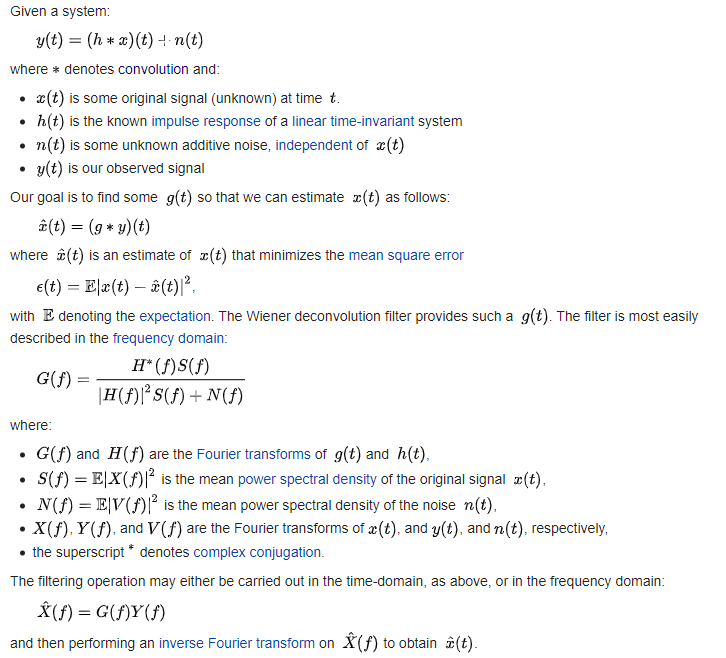

In [36]:
from deconvolution_analysis import ConvolutionLatticeImageAnalyzer 
from pathlib import Path

Paths for the raw data is assigned, the shot to be analyzed is specified:

In [37]:
raw_image_path = Path('data/Scan-20200201-0006.hdf')
psf_path = Path('data/20191216-0030.pkl')
shot_number = 4

Anaysis parameters:

In [38]:
M = 10 #Number of pixels per lattice site
angle = 47.5 #Angle by which the raw image is rotated
roi = [650, 1050, 720, 1120] #[x1,x2,y1,y2] Region of interest of the raw image
shift_up = 5 #Number of pixels by which the deconvolved image is shifted up such that atom locations match the lattice sites
shift_left = 0 #Number of pixels by which the deconvolved image is shifted left such that atom locations match the lattice sites
threshold_buffer = 0.5 #Threshold buffer to be added to the calculated threshold for binarizing the deconvolved image

In [41]:
# original = Path('data/20191216-0030.pkl')
# destination = Path('data/20191216-0030_win10.pkl')

# content = ''
# outsize = 0
# with open(original, 'rb') as infile:
    
#     content = infile.read()
# with open(destination, 'wb') as output:
    
#     for line in content.splitlines():
#         outsize += len(line) + 1
#         output.write(line + str.encode('\n'))

# print("Done. Saved %s bytes." % (len(content)-outsize))
# psf_path = Path('data/20191216-0030_win10.pkl')

Done. Saved 41 bytes.


If the following cell produces an unpickling error, it is possibly due to an incompatibility of the end of line standards employed on UNIX vs Windows machines. To resolve this, uncomment and run the preceding cell to create a windows compatible pickle.

In [42]:
single_site_image = ConvolutionLatticeImageAnalyzer(
    raw_image_path = raw_image_path,
    shot_number = shot_number,
    psf_path = psf_path,
    M=M,
    angle=angle,
    roi=roi,
    shift_up=shift_up,
    shift_left=shift_left, 
    threshold_buffer=threshold_buffer
)

data\20191216-0030_win10.pkl


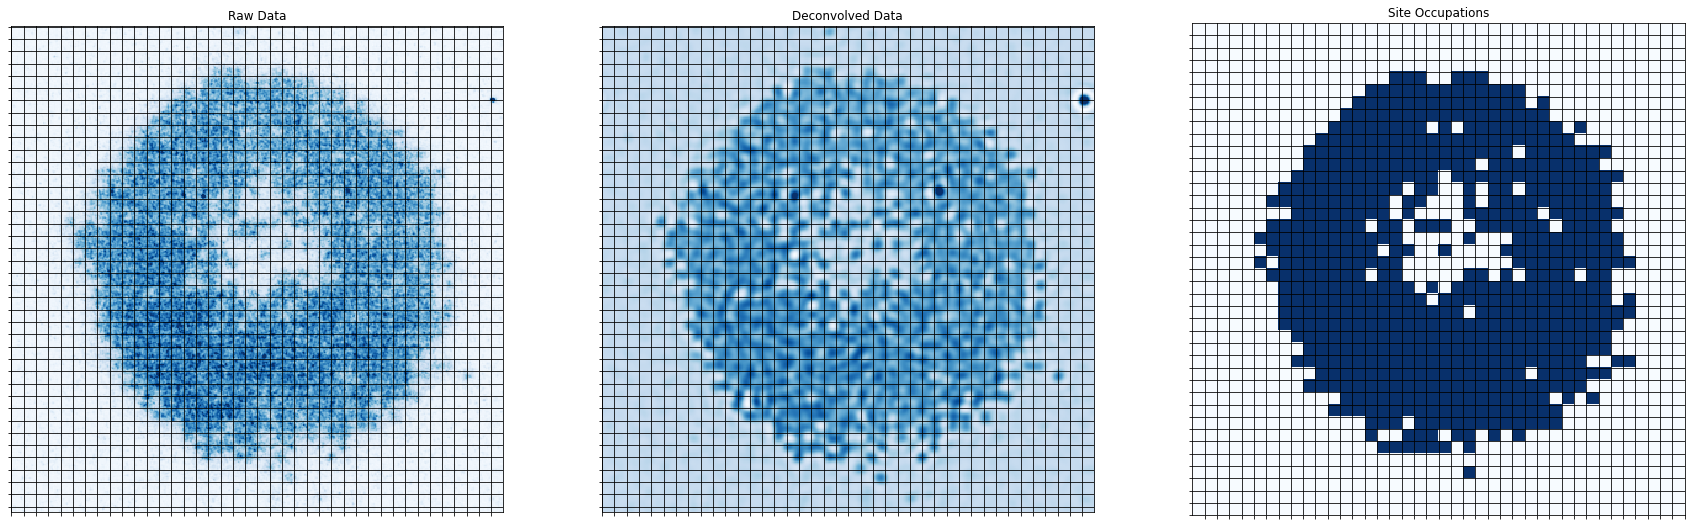

In [43]:
binarized = single_site_image.analyze_raw_data(plot=True, plot_hist=False) 